# Imports, install and mount

In [1]:
# ! pip install cuda
# ! pip install torch_geometric
# ! pip install dgl
# ! pip install nxontology
# ! pip install tensordict
# ! pip install numpy==1.22.1
# ! pip install pandas
# ! pip install tensorflow
# ! pip install scipy
# ! pip install pydantic
# ! pip install matplotlib

import random
import torch
import torch.optim as optim
import torch_geometric
from torch_geometric.nn import ComplEx
from torch_geometric.data import Data
import pandas as pd
from torch_geometric.loader import DataLoader
from nxontology.imports import from_file
import pickle
import wandb
import torch.nn.functional as F
import numpy as np

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.2.1) or chardet (5.2.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


# Settings and data loading


In [2]:
# Datas
mapped_iric_path = '/home/elliot/Documents/ESL2024/data/test_mapped_Os_to_GO_iric.tsv'
datasets_save_path = '/home/elliot/Documents/ESL2024/data/mapping_datasets_and_model_for_genes_to_phenotypes_iric/test_dataset_'

val_path = datasets_save_path + 'VAL' +  '.pickle'
test_path = datasets_save_path + 'TEST' +  '.pickle'
train_path = datasets_save_path + 'TRAIN' +  '.pickle'

# Model to load :
hidden_channels = 220

params_save_name = f"PARAMS_ComplEx_6_times_{hidden_channels}_HC_{500}_epochs_{4096}_BS_on_full_Os_GO"
model_parameters_path = "/home/elliot/Documents/ESL2024/data/mapping_datasets_and_model_for_genes_to_phenotypes_iric/"+params_save_name


# Model to re-train :
hidden_channels = 220
batch_size = 4096
epochs = 500
lin_factor = 0.5

params_save_name = f"PARAMS_ComplEx_6_times_{hidden_channels}_HC_{epochs}_epochs_{batch_size}_BS_on_full_Os_GO"
model_parameters_path = "/home/elliot/Documents/ESL2024/data/mapping_datasets_and_model_for_genes_to_phenotypes_iric/"+params_save_name

# Ontology
url = "/home/elliot/Documents/ESL2024/data/go-basic.json.gz"

# Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu' # Tip : Use cpu for debugging
print(device)


# wandb.init(
#     settings=wandb.Settings(start_method="fork"),
#     # set the wandb project where this run will be logged
#     project="ReTrain_ComplEx_with_LinSim()",
    
#     # track hyperparameters and run metadata
#     config={
#     "architecture": "ComplEx",
#     "dataset": "genes_to_phenotypes_iric.tsv",
#     "epochs": epochs,
#     'hidden_channels' : hidden_channels,
#     'batch_size' : batch_size
#     'lin_factore' : lin_factor
#     }
# )

cpu


In [3]:
mapped_iric = pd.read_csv(mapped_iric_path, sep = '\t')
display(mapped_iric)

GO_to_map = mapped_iric.set_index('object')['mapped_object'].to_dict()
map_to_GO = {value: key for key, value in GO_to_map.items()}


# Checking dict :
looks_ok: bool = True

print(len(list(mapped_iric['object'])))
for i in range(len(list(mapped_iric['object']))):
    if GO_to_map[mapped_iric['object'][i]]!=mapped_iric['mapped_object'][i]:
        looks_ok = False
    
print('Dict looks ok :', looks_ok)
print(map_to_GO)
print(GO_to_map)

,subject,predicate,object,mapped_subject,mapped_predicate,mapped_object
0,OsNippo01g010050,gene ontology,GO:0031267,30291,0,7906
1,OsNippo01g010050,gene ontology,GO:0006886,30291,0,25614
2,OsNippo01g010050,gene ontology,GO:0005622,30291,0,1674
3,OsNippo01g010050,gene ontology,GO:0005623,30291,0,683
4,OsNippo01g010050,gene ontology,GO:0090630,30291,0,2381
...,...,...,...,...,...,...
169243,OsNippo12g248550,gene ontology,GO:0009409,11307,0,16360
169244,OsNippo12g248550,gene ontology,GO:0001666,11307,0,29537
169245,OsNippo12g250550,gene ontology,GO:0008270,7838,0,17885
169246,OsNippo12g255100,gene ontology,GO:0005576,22106,0,20658


169248
Dict looks ok : True
{7906: 'GO:0031267', 25614: 'GO:0006886', 1674: 'GO:0005622', 683: 'GO:0005623', 2381: 'GO:0090630', 13269: 'GO:0043087', 17944: 'GO:0005096', 18496: 'GO:0020037', 9117: 'GO:0016705', 7918: 'GO:0055114', 20620: 'GO:0004497', 18066: 'GO:0005506', 24743: 'GO:0009055', 7102: 'GO:0016722', 7196: 'GO:0005507', 8956: 'GO:0016491', 12133: 'GO:0005886', 23590: 'GO:0009506', 29027: 'GO:0046658', 25277: 'GO:0016020', 28520: 'GO:0003676', 16885: 'GO:0006412', 14796: 'GO:0019843', 8749: 'GO:0003723', 14049: 'GO:0042542', 23692: 'GO:0000028', 4996: 'GO:0022627', 16832: 'GO:0009651', 697: 'GO:0003735', 4684: 'GO:0009414', 10874: 'GO:0009737', 25458: 'GO:0050832', 14222: 'GO:0003729', 2387: 'GO:0005840', 1835: 'GO:0015935', 8214: 'GO:0005783', 16017: 'GO:0016829', 2529: 'GO:0006888', 1340: 'GO:0051788', 5037: 'GO:0006629', 6927: 'GO:0006635', 2059: 'GO:0043161', 16543: 'GO:0009751', 24161: 'GO:0030149', 4743: 'GO:0030170', 20767: 'GO:0009407', 18039: 'GO:0005789', 14764: '

In [4]:
from tqdm import tqdm
tqdm.pandas()

mapped_iric['mapped_alt_tails'] = mapped_iric.progress_apply(
                                             lambda row: 
                                             mapped_iric.loc[(mapped_iric['mapped_subject'] == row['mapped_subject']) & 
                                                             (mapped_iric['mapped_predicate'] == row['mapped_predicate']) & 
                                                             (mapped_iric['mapped_object'] != row['mapped_object']), 
                                                             'mapped_object'].values, 
                                             axis=1)
display(mapped_iric)

100%|██████████| 169248/169248 [01:59<00:00, 1417.50it/s]


,subject,predicate,object,mapped_subject,mapped_predicate,mapped_object,mapped_alt_tails
0,OsNippo01g010050,gene ontology,GO:0031267,30291,0,7906,"[25614, 1674, 683, 2381, 13269, 17944]"
1,OsNippo01g010050,gene ontology,GO:0006886,30291,0,25614,"[7906, 1674, 683, 2381, 13269, 17944]"
2,OsNippo01g010050,gene ontology,GO:0005622,30291,0,1674,"[7906, 25614, 683, 2381, 13269, 17944]"
3,OsNippo01g010050,gene ontology,GO:0005623,30291,0,683,"[7906, 25614, 1674, 2381, 13269, 17944]"
4,OsNippo01g010050,gene ontology,GO:0090630,30291,0,2381,"[7906, 25614, 1674, 683, 13269, 17944]"
...,...,...,...,...,...,...,...
169243,OsNippo12g248550,gene ontology,GO:0009409,11307,0,16360,"[4671, 7918, 7618, 30250, 10239, 29537]"
169244,OsNippo12g248550,gene ontology,GO:0001666,11307,0,29537,"[4671, 7918, 7618, 30250, 10239, 16360]"
169245,OsNippo12g250550,gene ontology,GO:0008270,7838,0,17885,[]
169246,OsNippo12g255100,gene ontology,GO:0005576,22106,0,20658,[30220]


In [5]:
mo = list(mapped_iric['mapped_object'])

In [6]:
4542 in list(mapped_iric['mapped_subject'])

True

In [7]:
mapped_alt_tails = {}

for index, row in mapped_iric.iterrows():
    key = (row['mapped_subject'], row['mapped_predicate'])
    if key not in mapped_alt_tails:
        mapped_alt_tails[key] = set()
    mapped_alt_tails[key].update(set(row['mapped_alt_tails']))

print(mapped_alt_tails)

for key, value in mapped_alt_tails.items():
    mapped_alt_tails[key]=np.array(list(value))

print(mapped_alt_tails[(30291, 0)])

{(30291, 0): {7906, 1674, 683, 2381, 25614, 13269, 17944}, (26171, 0): {18496, 24743, 20620, 7918, 18066, 9117}, (28554, 0): {29027, 12133, 23590, 7196, 7918, 8956, 7102}, (22289, 0): set(), (11448, 0): set(), (29609, 0): set(), (28422, 0): {16832, 4996, 1674, 23692, 14796, 4684, 14222, 2387, 14049, 1835, 8749, 25458, 16885, 697, 10874}, (18531, 0): {4743, 2059, 6927, 272, 16017, 8214, 20767, 16543, 14764, 5037, 13239, 20540, 1340, 25277, 16583, 5063, 22473, 2529, 24161, 25458, 18039, 6526}, (9699, 0): {1122, 7802, 25275, 8749}, (13762, 0): {1440, 28520, 8749, 5326, 30359, 17885}, (8789, 0): {19933, 22405, 10539, 27245, 22861, 5074, 8214, 7802, 5021}, (3456, 0): set(), (28068, 0): {3713, 2494, 4684, 5021, 16360, 14764, 5932, 21102, 4729, 19006}, (30155, 0): {21891, 21385, 14484, 2108, 14909}, (20944, 0): {1674, 25750, 4952, 8417, 22051, 27883, 1465, 7802, 25275, 24637, 15226}, (6212, 0): {2848, 21891, 21262, 10746, 5021, 26879}, (14503, 0): {25277, 8214}, (12623, 0): {20362, 9168, 5200

In [8]:
val_data = torch.load(val_path)
test_data = torch.load(test_path)
train_data = torch.load(train_path)

print("Datatsets look OK ? (val, train, test) :",
val_data.validate(),
test_data.validate(),
train_data.validate())

print(val_data)
print(test_data)
print(train_data)

Datatsets look OK ? (val, train, test) : True True True
Data(edge_index=[2, 135400], edge_attr=[135400], num_nodes=30396, edge_label=[33848], edge_label_index=[2, 33848])
Data(edge_index=[2, 152324], edge_attr=[152324], num_nodes=30396, edge_label=[33848], edge_label_index=[2, 33848])
Data(edge_index=[2, 135400], edge_attr=[135400], num_nodes=30396, edge_label=[135400], edge_label_index=[2, 135400])


In [28]:
subs = set(list(mapped_iric['mapped_subject']))
objs = set(list(mapped_iric['mapped_object']))

heads = set(train_data.edge_index[0].tolist())
tails = set(train_data.edge_index[1].tolist())

print('Number of heads in dataset  :', len(heads))
print('difference heads - subjects :', len(heads-subs))
print('difference heads - object   :', len(heads-objs))

# len('Numer of tails in dataset     :', len(tails))
print('Difference tails - subjects :', len(tails-subs))
print('Differece tails - objects    :', len(tails-objs))

Number of heads in dataset  : 22620
difference heads - subjects : 0
difference heads - object   : 22620
Difference tails - subjects : 6579
Differece tails - objects    : 0


In [31]:
print(len(subs - tails))
print(len(subs - tails))

23377


In [11]:
# Here I create a batch on wich i will test my losses. I need a loader and a model to create it.

complex_model = ComplEx(
    num_nodes=train_data.num_nodes,
    num_relations = train_data.edge_index.size()[1],
    hidden_channels=hidden_channels,
).to(device)

loader = complex_model.loader(
    head_index = train_data.edge_index[0],
    tail_index = train_data.edge_index[1],
    rel_type = train_data.edge_attr,
    batch_size=batch_size,
    shuffle=False,)

batchy = next(iter(loader))
print(batchy)
hi, rt, ti = batchy[0], batchy[1], batchy[2]
print(hi,'\n',rt,'\n', ti)

(tensor([ 1073, 13909, 29976,  ..., 27744,  1058, 21484]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([24545, 14540, 25275,  ...,   697, 22725, 19894]))
tensor([ 1073, 13909, 29976,  ..., 27744,  1058, 21484]) 
 tensor([0, 0, 0,  ..., 0, 0, 0]) 
 tensor([24545, 14540, 25275,  ...,   697, 22725, 19894])


# Defining LinLoss()

In [94]:
nxo = from_file('/home/elliot/Documents/ESL2024/data/go-basic.json.gz')
nxo.freeze()
print(nxo)

In [95]:
print(nxo.__dict__)

{'graph': <networkx.classes.digraph.DiGraph object at 0x7f34d6f15520>, '_node_info_cache': {}, 'pronto': Ontology('/home/elliot/Documents/ESL2024/data/go-basic.json.gz')}


In [99]:
d = nxo.graph._node

In [101]:
for k, v in d.items():
    print(k)

GO:0000001
GO:0000002
GO:0000003
GO:0000006
GO:0000007
GO:0000009
GO:0000010
GO:0000011
GO:0000012
GO:0000014
GO:0000015
GO:0000016
GO:0000017
GO:0000018
GO:0000019
GO:0000022
GO:0000023
GO:0000024
GO:0000025
GO:0000026
GO:0000027
GO:0000028
GO:0000030
GO:0000031
GO:0000032
GO:0000033
GO:0000034
GO:0000035
GO:0000036
GO:0000038
GO:0000041
GO:0000045
GO:0000048
GO:0000049
GO:0000050
GO:0000052
GO:0000053
GO:0000054
GO:0000055
GO:0000056
GO:0000062
GO:0000064
GO:0000070
GO:0000073
GO:0000075
GO:0000076
GO:0000077
GO:0000079
GO:0000080
GO:0000082
GO:0000084
GO:0000085
GO:0000086
GO:0000087
GO:0000088
GO:0000089
GO:0000090
GO:0000091
GO:0000092
GO:0000093
GO:0000095
GO:0000096
GO:0000097
GO:0000098
GO:0000099
GO:0000100
GO:0000101
GO:0000102
GO:0000103
GO:0000104
GO:0000105
GO:0000107
GO:0000109
GO:0000110
GO:0000111
GO:0000112
GO:0000113
GO:0000118
GO:0000120
GO:0000121
GO:0000122
GO:0000123
GO:0000124
GO:0000126
GO:0000127
GO:0000128
GO:0000131
GO:0000132
GO:0000133
GO:0000136
GO:0000137

In [194]:
def best_lim_sim_for_triple(head: torch.Tensor, rel: torch.Tensor, tail: torch.Tensor,
                            alternative_tails: dict,
                            ontology:'nxontology.ontology.NXOntology'
                            )-> float:
    
    head, rel, tail = head.item(), rel.item(), tail.item() 
    lin_sims = []
    for alt_tail in alternative_tails[(head, rel)]:
        try :
            lin_sims.append(ontology.similarity(map_to_GO[tail], map_to_GO[alt_tail]).lin)
        except :
            lin_sims.append(0)
    
    return torch.Tensor(max(lin_sims))


def fast_best_lim_sim_for_triple(head: torch.Tensor, rel: torch.Tensor, tail: torch.Tensor,
                                alternative_tails: dict,
                                ontology: 'nxontology.ontology.NXOntology') -> float:
    
    head, rel, tail = head.item(), rel.item(), tail.item() 

    
    lin_sims = [
        ontology.similarity(map_to_GO[tail], map_to_GO[alt_tail]).lin
        if (map_to_GO[tail] in ontology.graph._node and map_to_GO[alt_tail] in ontology.graph._node)
        else 0
        for alt_tail in alternative_tails.get((head, rel), [])
    ]
    
    return torch.Tensor(max(lin_sims))


In [192]:
t = (batchy[0][0], batchy[1][0], batchy[2][0])


In [195]:
# %%timeit
## To make it work, make the function return a float.

# fast_best_lim_sim_for_triple(*t,
#                         alternative_tails=mapped_alt_tails,
#                         ontology=nxo)

TypeError: new(): data must be a sequence (got float)

In [175]:
# %%timeit

# ## To make it work, make the function return a float.
# best_lim_sim_for_triple(*t,
#                         alternative_tails=mapped_alt_tails,
#                         ontology=nxo)

142 µs ± 1.15 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [177]:
tensor = torch.tensor([[0,0,1],[0,1,1],[1,1,1],[2,0,2],[3,1,1],[2,2,2]],dtype=torch.float)
print(tensor)
b = torch.vmap(func=sum,
               in_dims = 0)
print(b)
print(b(tensor))

tensor([[0., 0., 1.],
        [0., 1., 1.],
        [1., 1., 1.],
        [2., 0., 2.],
        [3., 1., 1.],
        [2., 2., 2.]])
<function vmap.<locals>.wrapped at 0x7f34d29c7430>
tensor([1., 2., 3., 4., 5., 6.])


In [183]:
vec_batchy = torch.stack([batchy[i] for i in range(len(batchy))])
print(vec_batchy)

tensor([[ 1073, 13909, 29976,  ..., 27744,  1058, 21484],
        [    0,     0,     0,  ...,     0,     0,     0],
        [24545, 14540, 25275,  ...,   697, 22725, 19894]])


In [185]:
lin_sims_for_batch = torch.vmap(func=best_lim_sim_for_triple,
                                in_dims = 1)
lin_sims_for_batch(*batchy)

ValueError: vmap(best_lim_sim_for_triple, in_dims=1, ...)(<inputs>): Got in_dim=1 for some input, but that input is a Tensor of dimensionality 1 so expected in_dim to satisfy -1 <= in_dim < 1.

In [169]:
lin_sims_for_batch = torch.vmap(
    func=lambda x: best_lim_sim_for_triple(
        head=x.unbind(0)[0],  # Accéder à la première composante
        rel=x.unbind(0)[1],    # Accéder à la deuxième composante
        tail=x.unbind(0)[2],   # Accéder à la troisième composante
        alternative_tails=mapped_alt_tails,
        ontology=nxo
    ),
    in_dims=1
)

lin_sims_for_batch(vec_batchy)


KeyError: (BatchedTensor(lvl=1, bdim=0, value=
    tensor([ 1073, 13909, 29976,  ..., 27744,  1058, 21484])
), BatchedTensor(lvl=1, bdim=0, value=
    tensor([0, 0, 0,  ..., 0, 0, 0])
))

In [ ]:
class tail_only_ComplEx(ComplEx):

    '''
    Overwritting random_sample() to make negative triples by setting a random tail to each triple,
    instead of setting a random head or tail.
    '''
    @torch.no_grad()
    def random_sample(
        self,
        head_index: torch.Tensor,
        rel_type: torch.Tensor,
        tail_index: torch.Tensor,
        ) -> torch.Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:

        """
        Randomly samples negative triplets by either replacing the tail.
        Args:
            head_index (torch.Tensor): The head indices.
            rel_type (torch.Tensor): The relation type.
            tail_index (torch.Tensor): The tail indices.
        """

        num_negatives = tail_index.numel()
        rnd_index = torch.randint(self.num_nodes, head_index.size(), device=head_index.device)

        tail_index = tail_index.clone()
        tail_index[num_negatives:] = rnd_index[num_negatives:]

        return head_index, rel_type, tail_index

In [ ]:
class lin_ComplEx(tail_only_ComplEx):
  def loss(
            self,
            head_index: torch.Tensor,
            rel_type: torch.Tensor,
            tail_index: torch.Tensor,
            ) -> torch.Tensor:
            
        '''
        tail_only_ComplEx.loss() modified to account a LinSim term.
        '''

        pos = head_index, rel_type, tail_index
        neg = self.random_sample(head_index, rel_type, tail_index)
        
        pos_score = self(*pos)
        neg_score = self(*neg)
        scores = torch.cat([pos_score, neg_score], dim=0)

        pos_target = torch.ones_like(pos_score) 
        neg_target = torch.zeros_like(neg_score)
        target = torch.cat([pos_target, neg_target], dim=0)

        return F.binary_cross_entropy_with_logits(scores, target)+1

(tensor([27637, 23657, 26610,  ..., 10721, 13931, 25916]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([14753,  2727, 25975,  ...,  2727, 17583, 15186]))
tensor([27637, 23657, 26610,  ..., 10721, 13931, 25916]) 
 tensor([0, 0, 0,  ..., 0, 0, 0]) 
 tensor([14753,  2727, 25975,  ...,  2727, 17583, 15186])


(tensor([ 7884, 24665, 11942,  ..., 21388, 13454, 10236]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([24562,  6360, 26389,  ...,  2497, 23727, 21238]))
tensor([ 7884, 24665, 11942,  ..., 21388, 13454, 10236]) 
 tensor([0, 0, 0,  ..., 0, 0, 0]) 
 tensor([24562,  6360, 26389,  ...,  2497, 23727, 21238])


In [ ]:
TO_complex_model = lin_ComplEx(
    num_nodes=train_data.num_nodes,
    num_relations = train_data.edge_index.size()[1],
    hidden_channels=hidden_channels,
).to(device)

TO_complex_model.loss(head_index=hi, tail_index=ti, rel_type=rt)

## Iniating models, test() and train()

In [ ]:
complex_model = ComplEx(
    num_nodes=train_data.num_nodes,
    num_relations = train_data.edge_index.size()[1],
    hidden_channels=hidden_channels,
).to(device)

with open(model_parameters_path, 'rb') as f:
    state_dict = pickle.load(f)

complex_model.load_state_dict(model_parameters_path)

lin_complex_model = complex_model

head_index = train_data.edge_index[0]
tail_index = train_data.edge_index[1]
rel_type = train_data.edge_attr

loader = complex_model.loader(
    head_index = head_index,
    tail_index = tail_index,
    rel_type = rel_type,
    batch_size=batch_size,
    shuffle=True,)

optimizer = optim.Adam(complex_model.parameters(),
                      #  lr=0.01, weight_decay=1e-6
                       )

UnpicklingError: A load persistent id instruction was encountered,
but no persistent_load function was specified.

In [ ]:
@torch.no_grad()
def best_lin_similarities(head_index, rel_type, tail_index):
    

In [ ]:
@torch.no_grad()
def test(data, model):
    model.eval()
    return model.test(
        head_index=data.edge_index[0],
        tail_index=data.edge_index[1],
        rel_type=data.edge_attr,
        batch_size=batch_size,
        k=10, #The k in Hit@k
    )

def train(loader, model, optimizer):
    model.train()
    total_loss = total_examples = 0
    for head_index, rel_type, tail_index in loader:
        optimizer.zero_grad()
        loss = model.loss(head_index, rel_type, tail_index)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * head_index.numel()
        total_examples += head_index.numel()
    return total_loss / total_examples

# Test model before modification

In [ ]:
test(data=test, model=complex_model)

## Training ComplEx

In [ ]:

start_rank, start_mrr, start_hits_at_10 = test(test_data)
print(f'Start Test Mean Rank: {start_rank:.2f}, Start Test MRR: {start_mrr:.4f}, '
      f'Start Test Hits@10: {start_hits_at_10:.4f}')

losses = []
for epoch in range(1, epochs):
    loss = train()
    losses.append(loss)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    if epoch % 500 == 0:
        rank, mrr, hits = test(val_data)
        print(f'Epoch: {epoch:03d}, Val Mean Rank: {rank:.2f}',
              f'Val MRR: {mrr:.4f}, Val Hits@10: {hits:.4f}')

rank, mrr, hits_at_10 = test(test_data)

print(f'Start Test Mean Rank: {start_rank:.2f}, Start Test MRR: {start_mrr:.4f}, '
      f'Start Test Hits@10: {start_hits_at_10:.4f}')
print(f'Final Test Mean Rank: {rank:.2f}, Final Test MRR: {mrr:.4f}, '
      f'Final Test Hits@10: {hits_at_10:.4f}')

torch.set_grad_enabled(False)

100%|██████████| 9001/9001 [00:15<00:00, 584.97it/s]


Start Test Mean Rank: 1653.85, Start Test MRR: 0.0029, Start Test Hits@10: 0.0033
Epoch: 001, Loss: 0.6931
Epoch: 002, Loss: 0.6931
Epoch: 003, Loss: 0.6931
Epoch: 004, Loss: 0.6931
Epoch: 005, Loss: 0.6931
Epoch: 006, Loss: 0.6931
Epoch: 007, Loss: 0.6931
Epoch: 008, Loss: 0.6931
Epoch: 009, Loss: 0.6931
Epoch: 010, Loss: 0.6931
Epoch: 011, Loss: 0.6931
Epoch: 012, Loss: 0.6931
Epoch: 013, Loss: 0.6931
Epoch: 014, Loss: 0.6930
Epoch: 015, Loss: 0.6930
Epoch: 016, Loss: 0.6930
Epoch: 017, Loss: 0.6930
Epoch: 018, Loss: 0.6929
Epoch: 019, Loss: 0.6929
Epoch: 020, Loss: 0.6929
Epoch: 021, Loss: 0.6928
Epoch: 022, Loss: 0.6928
Epoch: 023, Loss: 0.6927
Epoch: 024, Loss: 0.6926
Epoch: 025, Loss: 0.6925
Epoch: 026, Loss: 0.6925
Epoch: 027, Loss: 0.6923
Epoch: 028, Loss: 0.6922
Epoch: 029, Loss: 0.6921
Epoch: 030, Loss: 0.6920
Epoch: 031, Loss: 0.6918
Epoch: 032, Loss: 0.6916
Epoch: 033, Loss: 0.6914
Epoch: 034, Loss: 0.6912
Epoch: 035, Loss: 0.6910
Epoch: 036, Loss: 0.6907
Epoch: 037, Loss: 

100%|██████████| 9001/9001 [00:15<00:00, 581.03it/s]


Epoch: 500, Val Mean Rank: 78.60 Val MRR: 0.2849, Val Hits@10: 0.6920
Epoch: 501, Loss: 0.1044
Epoch: 502, Loss: 0.1021
Epoch: 503, Loss: 0.1038
Epoch: 504, Loss: 0.0987
Epoch: 505, Loss: 0.0997
Epoch: 506, Loss: 0.1007
Epoch: 507, Loss: 0.1002
Epoch: 508, Loss: 0.1014
Epoch: 509, Loss: 0.0979
Epoch: 510, Loss: 0.1011
Epoch: 511, Loss: 0.0971
Epoch: 512, Loss: 0.0990
Epoch: 513, Loss: 0.0993
Epoch: 514, Loss: 0.0943
Epoch: 515, Loss: 0.1006
Epoch: 516, Loss: 0.0984
Epoch: 517, Loss: 0.0972
Epoch: 518, Loss: 0.0934
Epoch: 519, Loss: 0.0952
Epoch: 520, Loss: 0.0961
Epoch: 521, Loss: 0.0944
Epoch: 522, Loss: 0.0981
Epoch: 523, Loss: 0.0966
Epoch: 524, Loss: 0.0923
Epoch: 525, Loss: 0.0968
Epoch: 526, Loss: 0.0960
Epoch: 527, Loss: 0.0958
Epoch: 528, Loss: 0.0938
Epoch: 529, Loss: 0.0917
Epoch: 530, Loss: 0.0985
Epoch: 531, Loss: 0.0901
Epoch: 532, Loss: 0.0894
Epoch: 533, Loss: 0.0933
Epoch: 534, Loss: 0.0918
Epoch: 535, Loss: 0.0941
Epoch: 536, Loss: 0.0937
Epoch: 537, Loss: 0.0920
Epoch

100%|██████████| 9001/9001 [00:15<00:00, 583.75it/s]


Epoch: 1000, Val Mean Rank: 73.25 Val MRR: 0.3136, Val Hits@10: 0.7798
Epoch: 1001, Loss: 0.0450
Epoch: 1002, Loss: 0.0433
Epoch: 1003, Loss: 0.0413
Epoch: 1004, Loss: 0.0436
Epoch: 1005, Loss: 0.0440
Epoch: 1006, Loss: 0.0473
Epoch: 1007, Loss: 0.0411
Epoch: 1008, Loss: 0.0440
Epoch: 1009, Loss: 0.0460
Epoch: 1010, Loss: 0.0411
Epoch: 1011, Loss: 0.0436
Epoch: 1012, Loss: 0.0474
Epoch: 1013, Loss: 0.0418
Epoch: 1014, Loss: 0.0433
Epoch: 1015, Loss: 0.0479
Epoch: 1016, Loss: 0.0412
Epoch: 1017, Loss: 0.0441
Epoch: 1018, Loss: 0.0428
Epoch: 1019, Loss: 0.0428
Epoch: 1020, Loss: 0.0454
Epoch: 1021, Loss: 0.0448
Epoch: 1022, Loss: 0.0439
Epoch: 1023, Loss: 0.0410
Epoch: 1024, Loss: 0.0434
Epoch: 1025, Loss: 0.0447
Epoch: 1026, Loss: 0.0435
Epoch: 1027, Loss: 0.0490
Epoch: 1028, Loss: 0.0409
Epoch: 1029, Loss: 0.0404
Epoch: 1030, Loss: 0.0413
Epoch: 1031, Loss: 0.0405
Epoch: 1032, Loss: 0.0495
Epoch: 1033, Loss: 0.0400
Epoch: 1034, Loss: 0.0443
Epoch: 1035, Loss: 0.0441
Epoch: 1036, Loss: 

100%|██████████| 9001/9001 [00:15<00:00, 572.55it/s]


Epoch: 1500, Val Mean Rank: 71.56 Val MRR: 0.3197, Val Hits@10: 0.7966
Epoch: 1501, Loss: 0.0335
Epoch: 1502, Loss: 0.0326
Epoch: 1503, Loss: 0.0314
Epoch: 1504, Loss: 0.0348
Epoch: 1505, Loss: 0.0327
Epoch: 1506, Loss: 0.0306
Epoch: 1507, Loss: 0.0324
Epoch: 1508, Loss: 0.0384
Epoch: 1509, Loss: 0.0315
Epoch: 1510, Loss: 0.0308
Epoch: 1511, Loss: 0.0307
Epoch: 1512, Loss: 0.0401
Epoch: 1513, Loss: 0.0294
Epoch: 1514, Loss: 0.0352
Epoch: 1515, Loss: 0.0373
Epoch: 1516, Loss: 0.0317
Epoch: 1517, Loss: 0.0388
Epoch: 1518, Loss: 0.0364
Epoch: 1519, Loss: 0.0346
Epoch: 1520, Loss: 0.0329
Epoch: 1521, Loss: 0.0315
Epoch: 1522, Loss: 0.0340
Epoch: 1523, Loss: 0.0312
Epoch: 1524, Loss: 0.0324
Epoch: 1525, Loss: 0.0320
Epoch: 1526, Loss: 0.0327
Epoch: 1527, Loss: 0.0334
Epoch: 1528, Loss: 0.0310
Epoch: 1529, Loss: 0.0337
Epoch: 1530, Loss: 0.0344
Epoch: 1531, Loss: 0.0380
Epoch: 1532, Loss: 0.0299
Epoch: 1533, Loss: 0.0326
Epoch: 1534, Loss: 0.0331
Epoch: 1535, Loss: 0.0323
Epoch: 1536, Loss: 

100%|██████████| 9001/9001 [00:15<00:00, 572.36it/s]


Epoch: 2000, Val Mean Rank: 70.24 Val MRR: 0.3227, Val Hits@10: 0.8059
Epoch: 2001, Loss: 0.0252
Epoch: 2002, Loss: 0.0281
Epoch: 2003, Loss: 0.0314
Epoch: 2004, Loss: 0.0335
Epoch: 2005, Loss: 0.0310
Epoch: 2006, Loss: 0.0308
Epoch: 2007, Loss: 0.0309
Epoch: 2008, Loss: 0.0299
Epoch: 2009, Loss: 0.0325
Epoch: 2010, Loss: 0.0314
Epoch: 2011, Loss: 0.0278
Epoch: 2012, Loss: 0.0283
Epoch: 2013, Loss: 0.0291
Epoch: 2014, Loss: 0.0309
Epoch: 2015, Loss: 0.0308
Epoch: 2016, Loss: 0.0352
Epoch: 2017, Loss: 0.0319
Epoch: 2018, Loss: 0.0290
Epoch: 2019, Loss: 0.0290
Epoch: 2020, Loss: 0.0264
Epoch: 2021, Loss: 0.0310
Epoch: 2022, Loss: 0.0297
Epoch: 2023, Loss: 0.0334
Epoch: 2024, Loss: 0.0317
Epoch: 2025, Loss: 0.0274
Epoch: 2026, Loss: 0.0296
Epoch: 2027, Loss: 0.0285
Epoch: 2028, Loss: 0.0305
Epoch: 2029, Loss: 0.0305
Epoch: 2030, Loss: 0.0308
Epoch: 2031, Loss: 0.0322
Epoch: 2032, Loss: 0.0282
Epoch: 2033, Loss: 0.0309
Epoch: 2034, Loss: 0.0290
Epoch: 2035, Loss: 0.0304
Epoch: 2036, Loss: 

100%|██████████| 9001/9001 [00:15<00:00, 571.59it/s]


Epoch: 2500, Val Mean Rank: 69.51 Val MRR: 0.3245, Val Hits@10: 0.8128
Epoch: 2501, Loss: 0.0300
Epoch: 2502, Loss: 0.0308
Epoch: 2503, Loss: 0.0288
Epoch: 2504, Loss: 0.0270
Epoch: 2505, Loss: 0.0294
Epoch: 2506, Loss: 0.0269
Epoch: 2507, Loss: 0.0251
Epoch: 2508, Loss: 0.0304
Epoch: 2509, Loss: 0.0307
Epoch: 2510, Loss: 0.0279
Epoch: 2511, Loss: 0.0285
Epoch: 2512, Loss: 0.0295
Epoch: 2513, Loss: 0.0257
Epoch: 2514, Loss: 0.0277
Epoch: 2515, Loss: 0.0297
Epoch: 2516, Loss: 0.0273
Epoch: 2517, Loss: 0.0285
Epoch: 2518, Loss: 0.0275
Epoch: 2519, Loss: 0.0250
Epoch: 2520, Loss: 0.0265
Epoch: 2521, Loss: 0.0255
Epoch: 2522, Loss: 0.0306
Epoch: 2523, Loss: 0.0234
Epoch: 2524, Loss: 0.0248
Epoch: 2525, Loss: 0.0262
Epoch: 2526, Loss: 0.0311
Epoch: 2527, Loss: 0.0280
Epoch: 2528, Loss: 0.0264
Epoch: 2529, Loss: 0.0288
Epoch: 2530, Loss: 0.0245
Epoch: 2531, Loss: 0.0288
Epoch: 2532, Loss: 0.0284
Epoch: 2533, Loss: 0.0278
Epoch: 2534, Loss: 0.0244
Epoch: 2535, Loss: 0.0297
Epoch: 2536, Loss: 

100%|██████████| 9001/9001 [00:15<00:00, 565.42it/s]

Start Test Mean Rank: 1653.85, Start Test MRR: 0.0029, Start Test Hits@10: 0.0033
Final Test Mean Rank: 69.00, Final Test MRR: 0.3254, Final Test Hits@10: 0.8157


## Testing ComplEx

In [ ]:
complex_model.to('cpu')
torch.set_grad_enabled(False)

# Is complex_model coherent ?
iric_first_line = iric.iloc[0].tolist()
map_tail = entity_to_mapping[iric_first_line[0]]
map_head = entity_to_mapping[iric_first_line[2]]
map_rel = relation_to_mapping[iric_first_line[1]]

print("Good score should appear here :")
print(complex_model(torch.tensor(map_tail),torch.tensor(map_rel),torch.tensor(map_head)))



print("Bad scores should appear here :")
print(complex_model(torch.tensor(random.choice(list(mapping_to_entity.keys()))),torch.tensor(0),torch.tensor(random.choice(list(mapping_to_entity.keys())))))
print(complex_model(torch.tensor(random.choice(list(mapping_to_entity.keys()))),torch.tensor(0),torch.tensor(random.choice(list(mapping_to_entity.keys())))))

Good score should appear here :
tensor(5.9803)
Bad scores should appear here :
tensor(-7.8395)
tensor(-11.2785)


## Making dict for association of embeddings and IDs (GO:XXXX)

In [ ]:
model_save_path = "TestComplEx"
loc_path = %pwd
torch.save(complex_model.state_dict(), model_save_path)
print(f'Model saved at {loc_path}/{model_save_path}')

Model saved at /home/elliot/Documents/ESL2024/code/TestComplEx


In [ ]:
def split_embed_triple(embed_triple):
    with torch.no_grad():
        embed_size = embed_triple.size()[0]
        tes = int(embed_size/3)
        h = embed_triple[0:tes]
        r = embed_triple[tes: 2*tes]
        t = embed_triple[2*tes: 3*tes]
        return h, r, t

### Defining loss

We use ID_from_embedding() with entity_product_embedding_to_ID (dict) to get  ID of each tensor when calculating alternative loss.

In [ ]:
nxo = from_file(url)
nxo.freeze()

In [ ]:
display(dataset)

,x,y
0,"[tensor(0.7692), tensor(0.7011), tensor(0.9309...",1
1,"[tensor(-0.7543), tensor(0.5537), tensor(0.231...",0
2,"[tensor(-1.0955), tensor(0.4813), tensor(0.370...",0
3,"[tensor(-0.4816), tensor(-1.0344), tensor(0.44...",0
4,"[tensor(0.5825), tensor(0.0847), tensor(0.7267...",1
...,...,...
50000,"[tensor(-0.2417), tensor(-0.0813), tensor(0.11...",1
50001,"[tensor(-0.7761), tensor(-0.6233), tensor(0.61...",0
50002,"[tensor(-0.6090), tensor(0.4403), tensor(-0.56...",0
50003,"[tensor(0.1454), tensor(0.1610), tensor(0.5300...",0


In [ ]:
def lin_similarity(term1:str, term2:str, ontology, error_return = 0):
  '''
  Returns the highier lin similarity of two entities of a list of given ontologies.
  /!\ If calculation is impossible (for example if one of the entities is in none of the ontologies), return 0.

  Parameters :
  - term1 (str): ID of the first entity as a string (example : "GO:0042552")
  - term2 (str): ID of the second entity as a string (example : "GO:0042552")
  - ontology (nxontology.ontology.NXOntology objects) : An ontology loaded with nxontology.
  - error_return : The output of the function if lin similarity cannot be calculated. Default 0.

  Returns :
  - linsim (float): The Lin similarity of the two entities in the ontology.
                    It is a a number in [0;1].
                    linsim(A,B) close of 0 means A and B are distant in the ontology ;
                    lisnsim(A,B) close of 1 means A and B are close entities in the ontology.
  '''  
  try :
      return ontology.similarity(term1, term2).lin
  except :
      # print(f'lin_similarity() : Error with {term1},{term2}. Returning {error_return}.')
      return error_return
  

def LinSim_errors_for_embed_triple(triple,
                                   ontology,
                                   possibles_tails_for_embed_head_rel_doubles:dict,
                                   entity_product_embedding_to_ID:dict,
                                   relation_product_embedding_to_ID:dict,
                                   error_return = 0):
  '''
  Given an embeddeded triple and an ontology, calculates the list of LinSim between the real head of the triple and the expected heads for the (head, relation) couple.

  Parameters :
  - triple (torch.Tensor): The concatenation of the embeddings of head, relation and tail.
  - ontology (list of nxontology.ontology.NXOntology objects) : An ontology loaded with nxontology.
  - possibles_tails_for_embed_head_rel_doubles (dict): a dict with KEYS : (last_times_first(head_embedding), last_times_first(relation_embedding))
                                                                   VALUES : The possibles tails for the head-tail couple in iric (ex :['GO:0005356', 'GO:0005356'])
  - entity_product_embedding_to_ID (dict): a dict with KEYS : last_times_first(head_embedding)
                                                       VALUES : The ID of an entity in the ontology (ex : 'GO:0005356')
  - relation_product_embedding_to_ID (dict): a dict with KEYS : last_times_first(relation_embedding)
                                                         VALUES : The ID of a relation (ex : 'is_a')
  - error_return : The output of the function if lin similarity cannot be calculated. Default 0.

  Returns :
  - similarities (list) : the list of LinSim between the actual triple head and the possible heads of the triple found in iric.
  '''
  with torch.no_grad():
    h_emb, r_emb, t_emb = split_embed_triple(triple)
    h_ID = ID_from_embedding(h_emb, entity_product_embedding_to_ID)
    r_ID = ID_from_embedding(r_emb, relation_product_embedding_to_ID)
    t_ID = ID_from_embedding(t_emb, entity_product_embedding_to_ID)
    
    possibles_tails = possibles_tails_for_embed_head_rel_doubles[(last_times_first(h_emb),last_times_first(r_emb))]
    # print(possibles_tails)
    similarities = [lin_similarity(t_ID, tail, ontology=ontology, error_return=error_return) for tail in possibles_tails]
    # print(similarities)
    
  return similarities

def best_lin_similarities_for_elements_of_batch(batch,
             possibles_tails_for_embed_head_rel_doubles,
             entity_product_embedding_to_ID,
             relation_product_embedding_to_ID,
             ontology,
             error_return=0):
    
    similarities = []
    for embed_triple in batch:
        similarities.append(max(LinSim_errors_for_embed_triple(triple = embed_triple,
                                                       possibles_tails_for_embed_head_rel_doubles = possibles_tails_for_embed_head_rel_doubles,
                                                       entity_product_embedding_to_ID = entity_product_embedding_to_ID,
                                                       relation_product_embedding_to_ID = relation_product_embedding_to_ID,
                                                       ontology=ontology,
                                                       error_return=error_return)))
            
    return torch.tensor(similarities, requires_grad=False)

print('Expect 0.06131261231205893 ; obtain',lin_similarity('GO:0000070' , 'GO:0050832', ontology=nxo, error_return=0))

test_size = 10
test_triples = list(dataset['x'][0:test_size])
ts = torch.stack(test_triples)
test_labels = list(dataset['y'][0:test_size])
tl = torch.tensor(test_labels)


print('An example of LinSim errors on embed triple :',LinSim_errors_for_embed_triple(
                               ts[0],possibles_tails_for_embed_head_rel_doubles = possibles_tails_with_product_keys,
                               entity_product_embedding_to_ID = entity_product_embedding_to_ID,
                               relation_product_embedding_to_ID = relation_product_embedding_to_ID,
                               ontology=nxo))

print("Best similarity from false tails to existing head :",max(best_lin_similarities_for_elements_of_batch(ts,possibles_tails_for_embed_head_rel_doubles = possibles_tails_with_product_keys,
                               entity_product_embedding_to_ID = entity_product_embedding_to_ID,
                               relation_product_embedding_to_ID = relation_product_embedding_to_ID,
                               ontology=nxo)))

print("Best similarities from false tails to existing heads :\n",best_lin_similarities_for_elements_of_batch(ts,possibles_tails_for_embed_head_rel_doubles = possibles_tails_with_product_keys,
                               entity_product_embedding_to_ID = entity_product_embedding_to_ID,
                               relation_product_embedding_to_ID = relation_product_embedding_to_ID,
                               ontology=nxo).mean())

Expect 0.06131261231205893 ; obtain 0.06131261231205893
An example of LinSim errors on embed triple : [0, 0.11671720698176603, 0.1591328371889264, 0.15474017244820315, 0.11645848882250898, 0.0, 1.0, 0.17796624679597664, 0.12518672208882034, 0.0]
Best similarity from false tails to existing head : tensor(1.)
Best similarities from false tails to existing heads :
 tensor(0.4698)


## Training

In [ ]:
batch_size = 1000
epochs = 1000

In [ ]:
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [ ]:

x = torch.stack(list(dataset['x']))
y = torch.tensor(dataset['y'], dtype=torch.float32).unsqueeze(dim=1)
print(x[0].dtype)
print(y[0].dtype)


X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# print(next(iter(train_loader)))

optimizer = torch.optim.Adam(lr = 0.1, params=classic.parameters())
criterion = nn.CrossEntropyLoss()

torch.float32
torch.float32


In [ ]:
# Is train loader coherent ? Yes : complex model gets better scores on positive than on negatives.
dist = nn.L1Loss()
batch = next(iter(train_loader))

# print(batch)
true_dists = []
false_dists = []
complex_preds_for_true = []
complex_preds_for_false = []

def complex_pred(h, r, t, model):

    h_map = torch.tensor(int(product_entities_embedding_to_mapping[last_times_first(h)]))
    t_map = torch.tensor(int(product_entities_embedding_to_mapping[last_times_first(t)]))
    r_map = torch.tensor(int(product_relation_embedding_to_mapping[last_times_first(r)]))

    return model(h_map,r_map,t_map)

def list_mean(list):
    return sum(list)/len(list)


complex_model(torch.tensor(map_tail),torch.tensor(map_rel),torch.tensor(map_head))
for i in range(len(batch[0])):

    tensor, label = batch[0][i], batch[1][i]
    h, r, t = split_embed_triple(tensor)

    if label.item()==1.0:
        true_dists.append(dist(h+r,t).item())
        complex_preds_for_true.append(complex_pred(h,r,t, model=complex_model))

    elif label.item()==0:
        false_dists.append(dist(h+r,t).item())
        complex_preds_for_false.append(complex_pred(h,r,t, model=complex_model))


print("Mean of True :", list_mean(true_dists))
print("Mean of false :", list_mean(false_dists))

print("Mean complex true scores :", list_mean(complex_preds_for_true))
print("Mean complex false scores :", list_mean(complex_preds_for_false))

Mean of True : 1.9733623434038996
Mean of false : 1.9715587981702098
Mean complex true scores : tensor(3.2996)
Mean complex false scores : tensor(-10.6214)


In [ ]:
print(min(complex_preds_for_true))
print(min(complex_preds_for_false))

tensor(-17.5699)
tensor(-25.0633)


Epochs : 10000, batch size : 1000.


100%|██████████| 10000/10000 [1:47:40<00:00,  1.55it/s]    


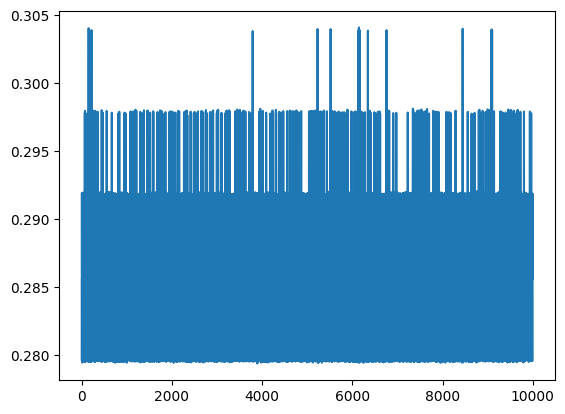

In [ ]:
classic.to(device)
classic.train()
loss = nn.L1Loss()
loss.requires_grad_ = True
epochs = 10000
optimizer = optim.SGD(params=classic.parameters(), lr=10)

print(f'Epochs : {epochs}, batch size : {batch_size}.')

losses = []
for epoch in tqdm(range(epochs)):
    batch_loss = []
    for batch_num, input_data in enumerate(train_loader):

        optimizer.zero_grad()
        
        x, y = input_data
        x = x.to(device)
        y = y.to(device)
        
        output = classic(x=x)
        output.requires_grad_(requires_grad=True)
        
        error = loss(output, y)
        error.requires_grad_(requires_grad=True)
        error.backward()
        
        batch_loss.append(error.item())
        
        optimizer.step()
        
    losses.append(sum(batch_loss)/len(batch_loss))

plt.plot(losses)

Epochs : 1000, batch size : 1000.


100%|██████████| 1000/1000 [04:51<00:00,  3.43it/s]


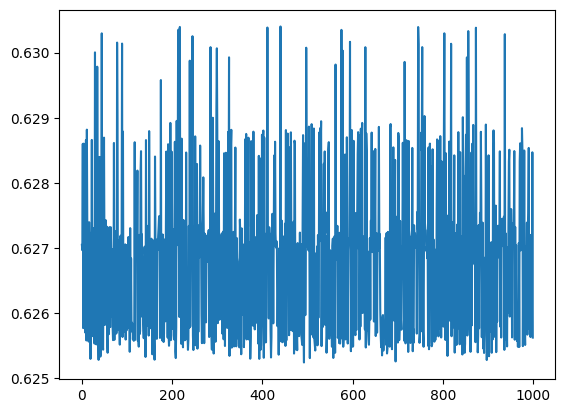

In [ ]:
classic.to(device)
classic.train()
loss = nn.L1Loss()
loss.requires_grad_ = True
epochs = 1000

print(f'Epochs : {epochs}, batch size : {batch_size}.')

losses = []
for epoch in tqdm(range(epochs)):
    batch_loss = []
    for batch_num, input_data in enumerate(train_loader):

        optimizer.zero_grad()
        
        x, y = input_data
        x = x.to(device)
        y = y.to(device)
        
        output = classic(x=x)
        output.requires_grad_(requires_grad=True)
        
        error = nn.functional.binary_cross_entropy_with_logits(output, y)

        error.requires_grad_(requires_grad=True)
        error.backward()
        
        batch_loss.append(error.item())
        
        optimizer.step()
        
    losses.append(sum(batch_loss)/len(batch_loss))

plt.plot(losses)

Epochs : 100, batch size : 1000.


100%|██████████| 100/100 [00:28<00:00,  3.55it/s]


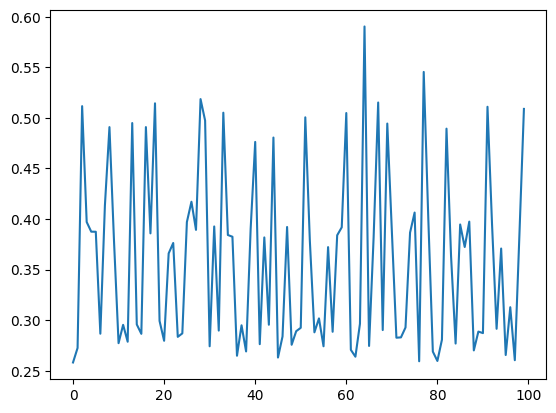

In [ ]:
# From notebook :

model.to(device)
model.train()
loss = nn.L1Loss()
loss.requires_grad_ = True
epochs = 100
print(f'Epochs : {epochs}, batch size : {batch_size}.')

losses = []
for epoch in tqdm(range(epochs)):

    for batch_num, input_data in enumerate(train_loader):

        batch_loss = []

        optimizer.zero_grad()

        x, y = input_data
        x = x.to(device)
        y = y.to(device)

        output = model(x=x)
        output.requires_grad_(requires_grad=True)

        error = loss(output, y)
        error.requires_grad_(requires_grad=True)
        error.backward()

        batch_loss.append(error.item())

        optimizer.step()

    losses.append(sum(batch_loss)/len(batch_loss))

plt.plot(losses)

In [ ]:
import numpy as np
import pandas as pd

# Fonction pour générer des tenseurs aléatoires de taille 10
def generate_random_tensor():
    return tonp.random.rand(input_size)

# Fonction pour déterminer si la somme des coordonnées du tenseur est supérieure à 5
def sum_greater_than_mean(tensor, input_size):
    return np.sum(tensor) > input_size/2

# Générer les tenseurs pour la colonne 'X'
tensors_X = [generate_random_tensor() for _ in range(100)]  # Générer 100 tenseurs

# Calculer les valeurs pour la colonne 'Y'
values_Y = [sum_greater_than_mean(tensor, input_size) for tensor in tensors_X]

# Créer le DataFrame
df = pd.DataFrame({'X': tensors_X, 'Y': values_Y})

# Afficher les 5 premières lignes du DataFrame
display(df)

x_easy = torch.stack(list(df['X']))
y_easy = torch.tensor(df['y'], dtype=torch.float32).unsqueeze(dim=1)
print(x_easy[0].dtype)
print(y_easy[0].dtype)

NameError: name 'tonp' is not defined

In [ ]:


X_train_easy, X_test_easy, y_train_easy, y_test_easy = train_test_split(x_easy, y_easy, test_size=0.2)

train_dataset_easy = TensorDataset(X_train_easy, y_train_easy)
train_loader_easy = DataLoader(train_dataset_easy, batch_size=batch_size, shuffle=True)

test_dataset_easy = TensorDataset(X_test_easy, y_test_easy)
test_loader_easy = DataLoader(test_dataset_easy, batch_size=batch_size, shuffle=True)

print(next(iter(train_loader_easy)))

optimizer = torch.optim.Adam(lr = 0.1, params=classic.parameters())
criterion = nn.CrossEntropyLoss()

classic.to(device)
classic.train()
loss = nn.L1Loss()
loss.requires_grad_ = True
epochs = 100
print(f'Epochs : {epochs}, batch size : {batch_size}.')

losses = []
for epoch in range(epochs):
    
    for batch_num, input_data in enumerate(train_loader_easy):

        batch_loss = []
        
        optimizer.zero_grad()
        
        x, y = input_data
        x = x.to(device)
        y = y.to(device)
        
        output = classic(x=x)
        output.requires_grad_(requires_grad=True)
        
        error = loss(output, y)
        error.requires_grad_(requires_grad=True)
        error.backward()
        
        batch_loss.append(error.item())
        
        optimizer.step()
        
    losses.append(sum(batch_loss)/len(batch_loss))

plt.plot(losses)

Accuracy : 0.237275


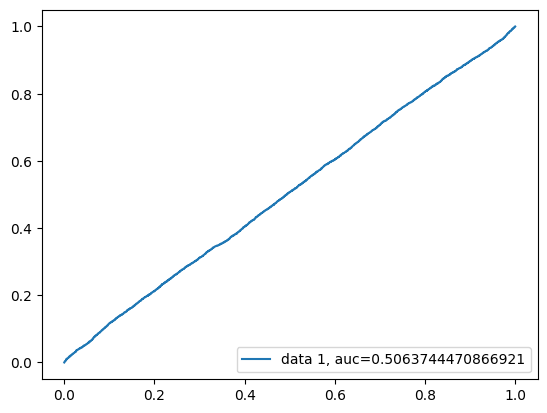

Accuracy : 0.2324


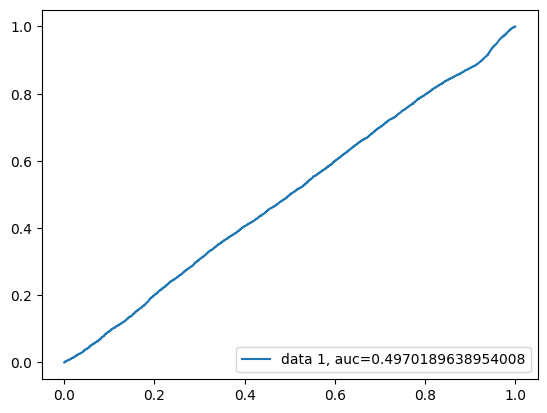

(0.2324,
 array([0.00000000e+00, 3.11944349e-05, 9.35833047e-05, ...,
        9.99937611e-01, 9.99968806e-01, 1.00000000e+00]),
 array([0.       , 0.       , 0.       , ..., 0.9998741, 1.       ,
        1.       ]),
 array([       inf, 0.5628371 , 0.5569319 , ..., 0.48338598, 0.4824607 ,
        0.4808096 ], dtype=float32))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_model(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    labels = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)
            predictions.extend(outputs.cpu().numpy())
            labels.extend(targets.cpu().numpy())

    # Convert predictions and labels to numpy arrays
    predictions = np.array(predictions)
    labels = np.array(labels)

    # Calculate accuracy
    accuracy = accuracy_score(labels, predictions.round())

    print('Accuracy :', accuracy)

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(labels, predictions)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr,tpr,label="data 1, auc="+str(roc_auc))
    plt.legend(loc=4)
    plt.show()

    return accuracy, fpr, tpr, thresholds

evaluate_model(model = untrained, data_loader=train_loader)
evaluate_model(model = classic, data_loader=train_loader)


In [ ]:
evaluate_model(model = classic, data_loader=train_loader)

# OLD

In [ ]:
def check_dict_chain(dicts:list, number_of_tests: int = 1):
    '''
    Parameters :
    -
    Returns :
    - 
    '''
    lengths = [len(dict) for dict in dicts]

    print(f'All dicts have the same size : {lengths.count(lengths[0])==len(lengths)}.') # Checking efficiently that all dicts have the same size
    for i in range(number_of_tests):
        found_no_error = False
        initial_key = random.choice(list(dicts[0].keys()))
        key = initial_key
        keys:list = [initial_key]
        for dict in dicts:
            try:
                key=dict[key]
                keys.append(key)
            except:
                raise KeyError(f"problem with key : {key} with type : {type(key)}.\nKeys list : {keys}\nProblematic dict :\n{dict}")
        print(f"Final key is equal initial key : {key == initial_key}.\nPath : {keys}")


In [ ]:


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Définition de la taille des données
num_samples = 1000
input_size = 10
hidden_size = 20
output_size = 1
batch_size = 32

# Création de données simulées
X_train = torch.randn(num_samples, input_size)
y_train = torch.randint(0, 2, (num_samples, output_size)).float()  # Génération de labels binaires aléatoires

# Création de DataLoader pour gérer les batchs
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Définition du modèle
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

model = MLP(input_size, hidden_size, output_size)

# Définition de la fonction de perte et de l'optimiseur
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Boucle d'entraînement
num_epochs = 100
for epoch in range(num_epochs):
    # Entraînement du modèle
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        print(type(input), inputs.size())
        loss.backward()
        optimizer.step()


        print(f'Epoch [{epoch+1}/{num_epochs}]')

# Évaluation du modèle
model.eval()
with torch.no_grad():
  total_correct = 0
  total_samples = 0
  for inputs, targets in train_loader:
    outputs = model(inputs)
    predicted = (outputs > 0.5).float()
    total_correct += (predicted == targets).sum().item()
    total_samples += targets.size(0)

    accuracy = total_correct / total_samples
    print(accuracy)

print("Entraînement terminé!")


<class 'method'> torch.Size([32, 10])


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn